# Riset Konversi PDF ke Gambar

**Tujuan**
- Membandingkan kecepatan convert file pdf ke file gambar
- Menentukan library yang digunakan untuk konversi pdf menjadi gambar

**Parameter:**
- PDF Converter Libraries: {pdf2image, pdfium, pymupdf}
- DPI: {300, 250, 200, 150, 100, 50, 20, 10, 5, 1}
- Waktu Konversi
- Render Options: {}

**Base perbandingan:**
- Kualitas gambar 300 DPI
- Waktu konversi pdf untuk kualitas gambar 300 DPI

**CSV Column for Comparisons:**
- datetime
- library_name
- dpi
- converting_time
- output_folder_size

**Output**
- file `cmyk_by_dpi_and_library.csv`

In [3]:
import sys
import os
from pdf2image import convert_from_path
import pymupdf
import pypdfium2 as pdfium
import time
from datetime import datetime
import re
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('../'))
from src.helper import get_folder_size, log, prepend_zero, calculate_cmyk_percentage

## **Variables**

In [1]:
dpi_list = list(range(10,0,-1)) + list(range(300, 49, -50)) + list(range(40,10, -10))
dpi_list

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 300, 250, 200, 150, 100, 50, 40, 30, 20]

## **Pdf2Image**

In [9]:
class PDFConverter:
    df_dict = {
        'library': [],
        'dpi': [],
        'converting_time': [],
        'page': [],
        'c': [],
        'm': [],
        'y': [],
        'k': [],
        'sum': [],
    }

    
    def __init__(self, file_path: str) -> None:
        self.file_path = file_path

    
    def pdf2img_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        
        pdf = convert_from_path(self.file_path, dpi=dpi, fmt='jpg')
        
        for index, page in enumerate(pdf):
            start = time.time()
            c, m, y, k = calculate_cmyk_percentage(page)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
        
        return pd.DataFrame(self.df_dict)


    def pymupdf_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        pdf = pymupdf.open(self.file_path)
       
        
        for index, page in enumerate(pdf):
            start = time.time()
            pixmap = page.get_pixmap(dpi=dpi)
            img = Image.open(io.BytesIO(pixmap.tobytes()))
    
            c, m, y, k = calculate_cmyk_percentage(img)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
    
        return pd.DataFrame(self.df_dict)

    def pdfium_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        start = time.time()
        pdf = pdfium.PdfDocument(self.file_path)
        
        for index, page in enumerate(pdf):
            start = time.time()
            bitmap = pdf[index].render(
                scale = 1/72 * dpi,
            )
            img = bitmap.to_pil()
            c, m, y, k = calculate_cmyk_percentage(img)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
    
        return pd.DataFrame(self.df_dict)

    def reset_df_dict(self):
         self.df_dict = {
            'library': [],
             'dpi': [],
            'converting_time': [],
            'page': [],
            'c': [],
            'm': [],
            'y': [],
            'k': [],
            'sum': [],
         }

    def df_dict_appender(self, c, m, y, k, index, start, dpi):
        sum_ = c + m + y + k
        self.df_dict['library'].append('pdfium')
        self.df_dict['dpi'].append(dpi)
        self.df_dict['page'].append(index+1)
        self.df_dict['c'].append(c)
        self.df_dict['m'].append(m)
        self.df_dict['y'].append(y)
        self.df_dict['k'].append(k)
        self.df_dict['sum'].append(sum_)
        self.df_dict['converting_time'].append(time.time() - start)
    

In [10]:
conv = PDFConverter("../datasets/statistik-indonesia-2024-combined.pdf")

In [ ]:
df_dict = {
    'library': [],
    'dpi': [],
    'converting_time': [],
}


for dpi in dpi_list:
    print(f"Converting {dpi} dpi")
    start = time.time()
    
    df_temp = conv.pdf2img_converter(dpi)
    df_dict['library'].append('pdf2mg')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)

    df_temp.to_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi.csv", mode='a', index=False, header=False)

    start = time.time()
    df_temp = conv.pymupdf_converter(dpi)
    df_dict['library'].append('pymupdf')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)

    df_temp.to_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi.csv", mode='a', index=False, header=False)
    
    start = time.time()
    df_temp = conv.pdfium_converter(dpi)
    df_dict['library'].append('pdfium')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)

    df_temp.to_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi.csv", mode='a', index=False, header=False)


df_cvt = pd.DataFrame(df_dict)
df_cvt.to_csv("../outputs/csv/pdf_to_img_converting_time_by_libraries.csv", index=False)

In [27]:
df_cvt.head(5)

,library,dpi,converting_time
0,pdf2mg,10,16.536244
1,pymupdf,10,9.134181
2,pdfium,10,12.991767
3,pdf2mg,9,15.952207
4,pymupdf,9,7.832357


In [28]:
df_cvt.sort_values(['dpi', 'library'], inplace=True)
df_cvt.to_csv("../outputs/csv/pdf_to_img_converting_time_by_libraries.csv", index=False, mode='a', )

---

In [24]:
import pandas as pd
df = pd.read_csv("../outputs/csv/pdf_to_img_converting_time_by_libraries.csv")
df.head()

,library,dpi,converting_time
0,pdf2mg,1,15.983651
1,pdfium,1,12.641955
2,pymupdf,1,9.124531
3,pdf2mg,2,13.914513
4,pdfium,2,13.394879


## Konversi Digit Nama File Menjadi 3 Digit

In [3]:
dpi_list = [200]
for dpi in dpi_list:
    for f in os.listdir(f"../outputs/pdfium_{dpi}dpi"):
        os.rename(f"../outputs/pdfium_{dpi}dpi/{f}", f"../outputs/pdfium_{dpi}dpi/{prepend_zero(f)}")

## Perbandingan Antara 3 Library Converter PDF ke Gambar

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
import seaborn as sns

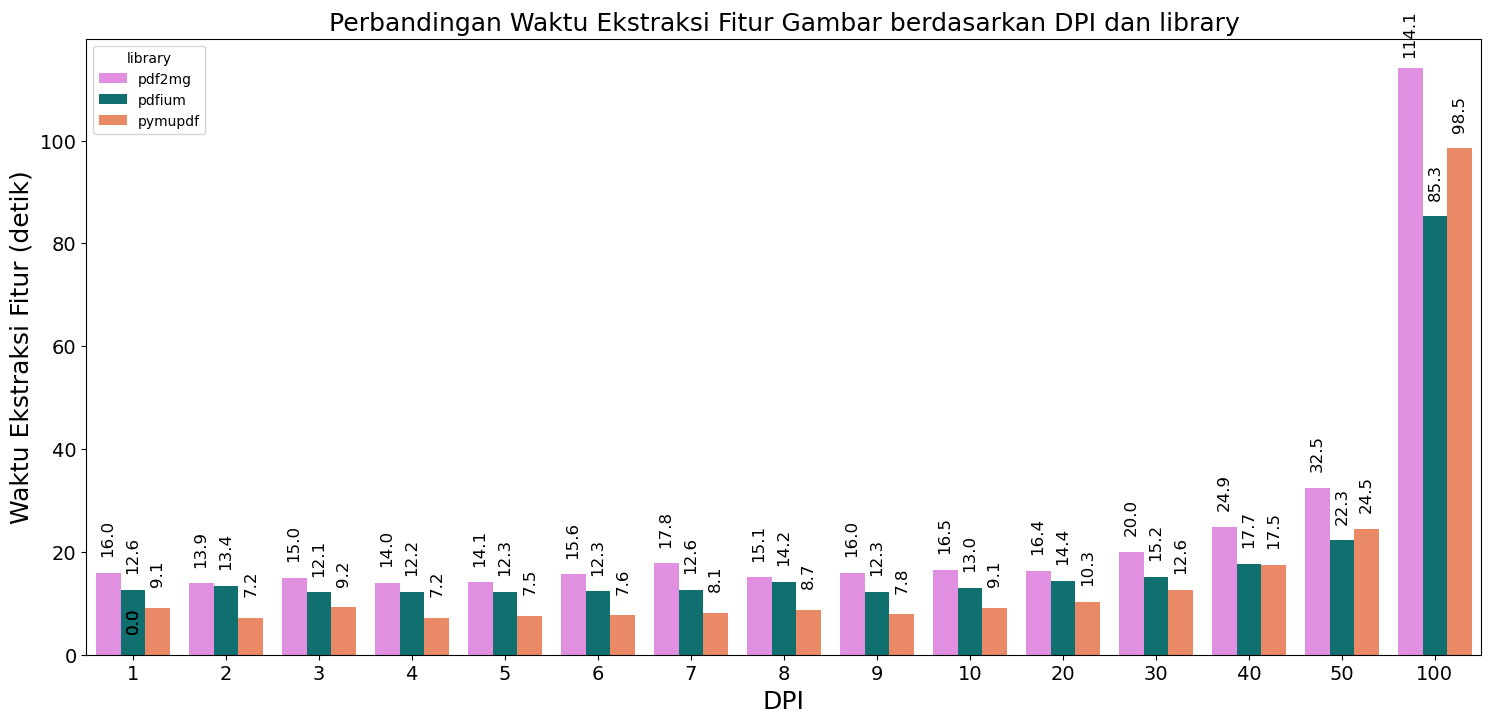

In [31]:
plt.figure(figsize=(18,8))
ax =sns.barplot(data=df[df.dpi <=100], x='dpi', y='converting_time', hue='library', palette=['violet', 'teal', 'coral'])
plt.xlabel("DPI")

# Menambahkan nilai di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',  # Teks yang ingin ditampilkan
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
                ha='center',  # Horizontal alignment
                va='center',  # Vertical alignment
                fontsize=12,   # Ukuran font
                color='black', # Warna font
                xytext=(0, 25), # Jarak teks dari bar
                textcoords='offset points', # Menggunakan offset dalam point
                rotation=90)  # Teks vertikal

plt.xlabel("DPI", fontsize=18)
plt.ylabel("Waktu Ekstraksi Fitur (detik)", fontsize=18)
plt.title("Perbandingan Waktu Ekstraksi Fitur Gambar berdasarkan DPI dan library", fontsize=18)
plt.xticks(fontsize=14)  # Ukuran font untuk xticks
plt.yticks(fontsize=14)  # Ukuran font untuk yticks

plt.show()


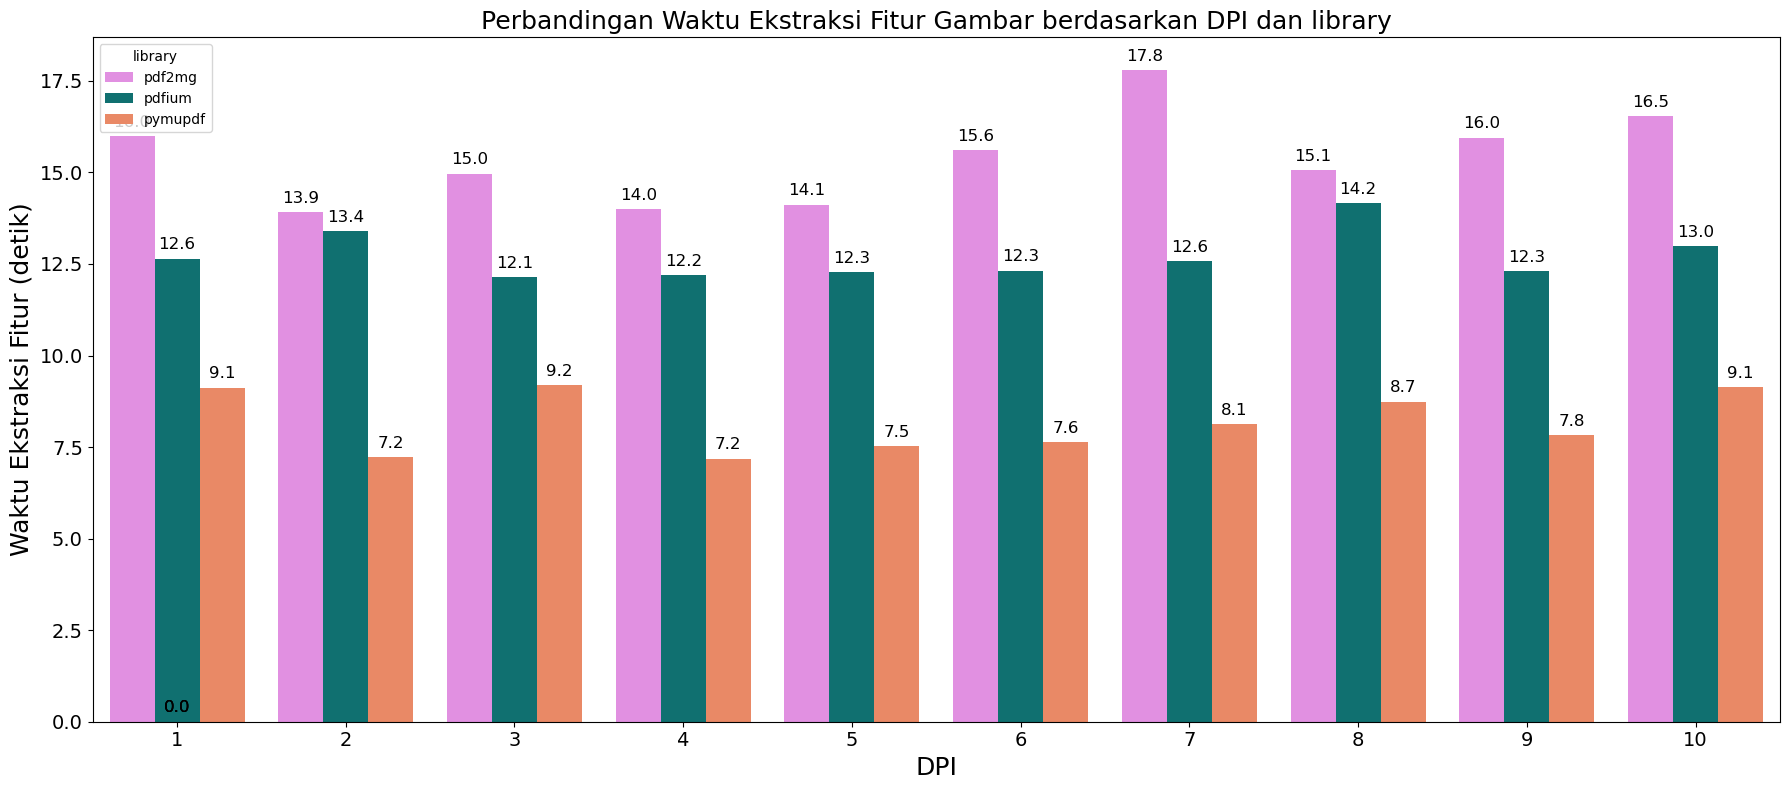

In [25]:
plt.figure(figsize=(18,8))
ax = sns.barplot(data=df[df.dpi <= 10], x='dpi', y='converting_time', hue='library', palette=['violet', 'teal', 'coral'])

# Menambahkan nilai di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',  # Teks yang ingin ditampilkan
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
                ha='center',  # Horizontal alignment
                va='center',  # Vertical alignment
                fontsize=12,   # Ukuran font
                color='black', # Warna font
                xytext=(0, 10), # Jarak teks dari bar
                textcoords='offset points')  # Menggunakan offset dalam point

    
plt.xlabel("DPI", fontsize=18)
plt.ylabel("Waktu Ekstraksi Fitur (detik)", fontsize=18)
plt.title("Perbandingan Waktu Ekstraksi Fitur Gambar berdasarkan DPI dan library", fontsize=18)
plt.xticks(fontsize=14)  # Ukuran font untuk xticks
plt.yticks(fontsize=14)  # Ukuran font untuk yticks

plt.tight_layout()
plt.show()

In [17]:
df[df.dpi <= 50].sort_values(['converting_time', 'dpi'])

,library,dpi,converting_time
11,pymupdf,4,7.187359
5,pymupdf,2,7.216622
14,pymupdf,5,7.521678
17,pymupdf,6,7.639638
26,pymupdf,9,7.832357
20,pymupdf,7,8.131164
23,pymupdf,8,8.734005
2,pymupdf,1,9.124531
29,pymupdf,10,9.134181
8,pymupdf,3,9.191975


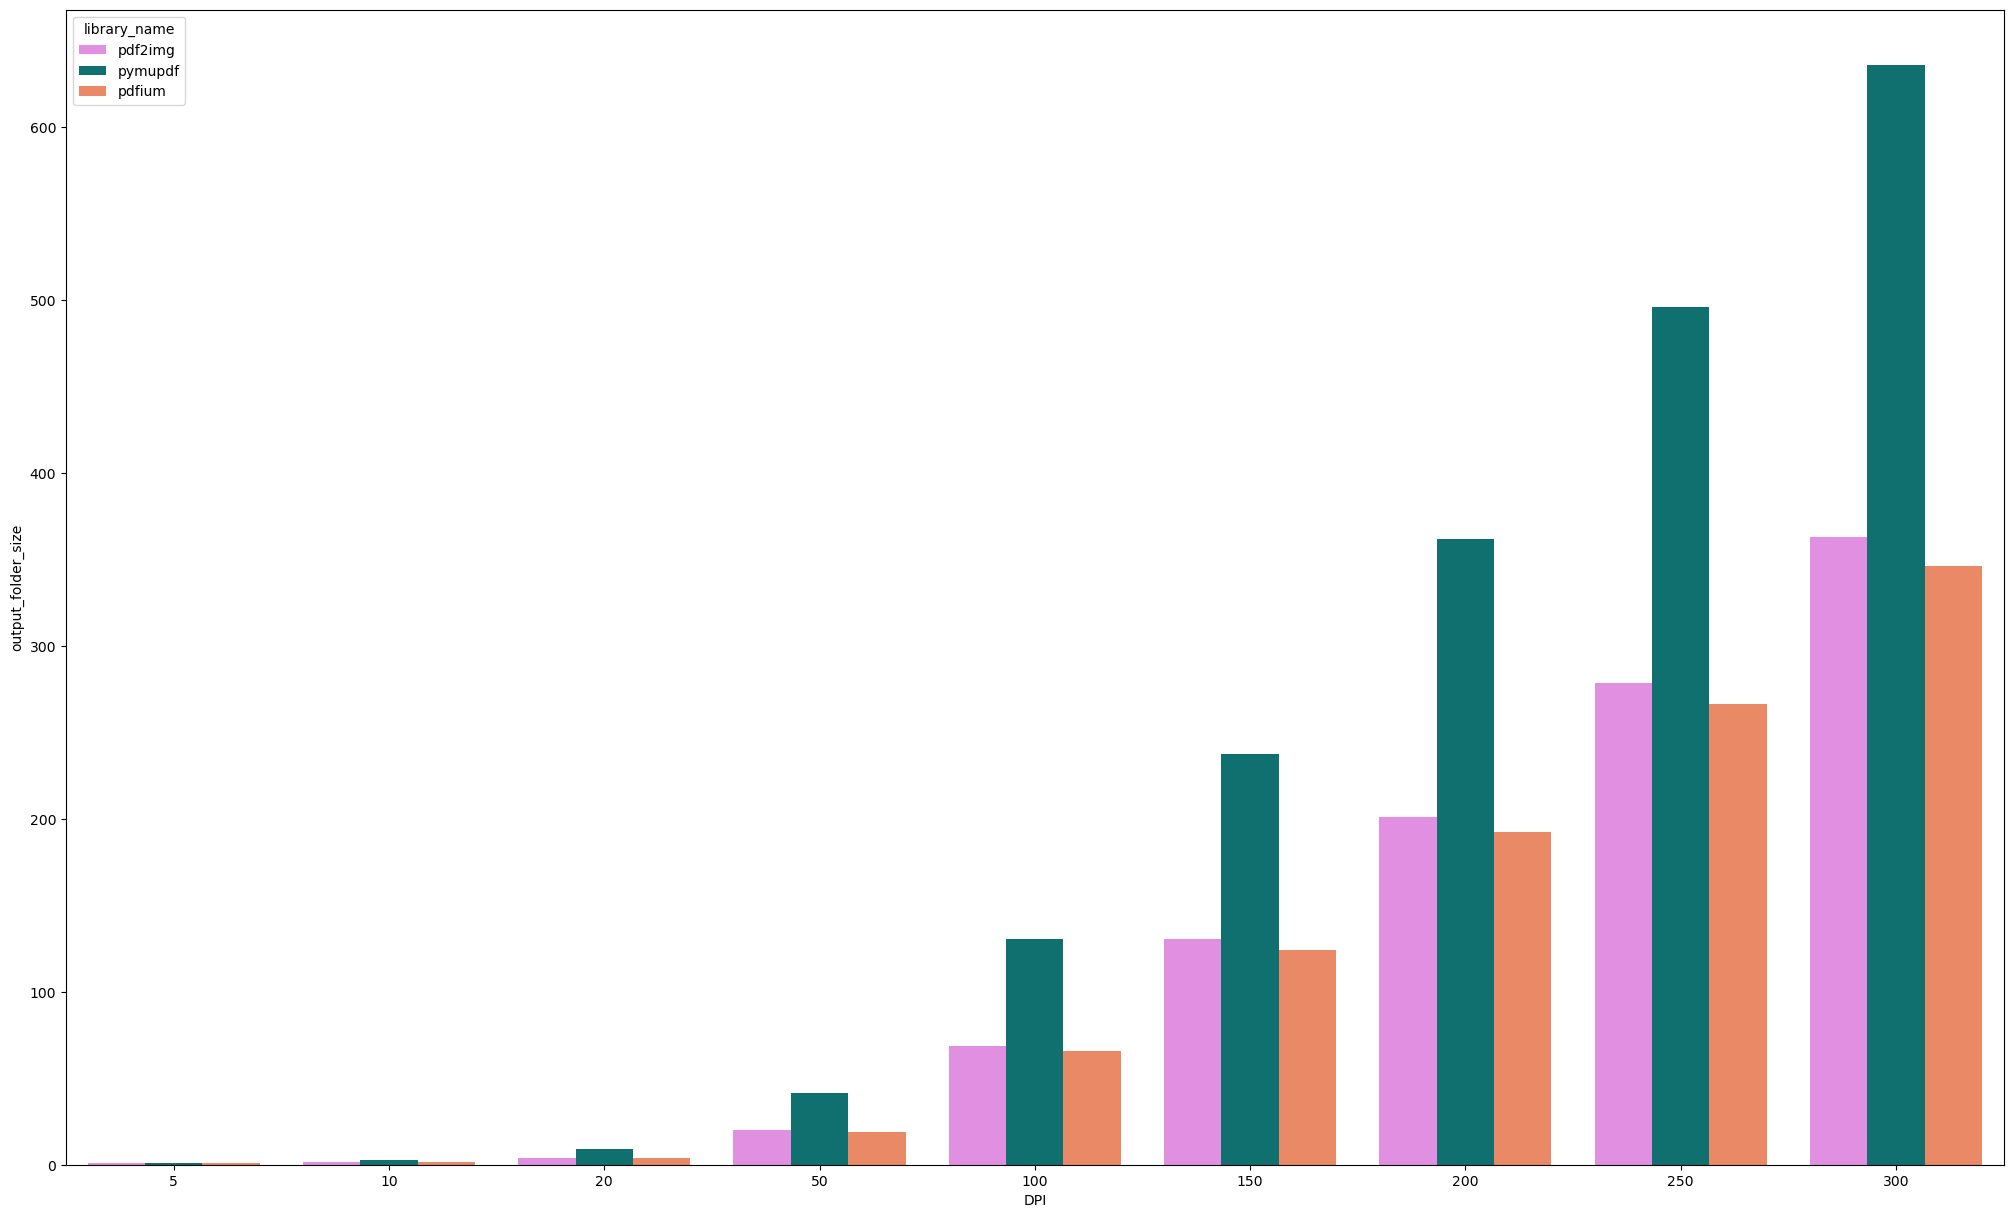

In [55]:
plt.figure(figsize=(25,15))
sns.barplot(data=df, x='dpi', y='output_folder_size', hue='library_name', palette=['violet', 'teal', 'coral'])
plt.xlabel("DPI")
plt.show()

## Kesimpulan
Library `pdfium` memiliki kecepatan paling tinggi dan total ukuran file paling rendah daripada `pdf2img` dan `PyMuPDF`

In [109]:
import pathlib

r = pathlib.Path().resolve().parent

In [110]:
r.joinpath("output/csv/")

PosixPath('/Users/rasyidev/Documents/rasyidevcode/print-cost/output/csv')

In [7]:
a = pd.DataFrame(columns=['c', 'm', 'y', 'k', 'sum'])

In [ ]:
a.to_csv()